In [347]:
import sqlite3
import pandas as pd
import numpy as np
from scipy.stats import norm
from scipy.optimize import minimize_scalar
from datetime import datetime

In [2]:
N = norm.cdf


In [3]:
def read_from_db():
    conn = sqlite3.connect('../../options_database.db')
    df = pd.read_sql_query("SELECT * FROM options_table", conn)
    conn.close()
    return df

In [4]:
df = read_from_db()

In [5]:
len(df[(df.current_time == '2023-01-29 11:24:46.988931')])

610

In [18]:
def delta_BS_put(S, K, T, r, sigma):
    d1 = (np.log(S/K) + (r + sigma**2/2)*T) / (sigma*np.sqrt(T))
    return N(d1) - 1

def delta_BS_call(S, K, T, r, sigma):
    d1 = (np.log(S/K) + (r + sigma**2/2)*T) / (sigma*np.sqrt(T))
    return N(d1)

def BS_CALL(S, K, T, r, sigma):
    d1 = (np.log(S/K) + (r + sigma**2/2)*T) / (sigma*np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
#     print(d1, d2)
    return S * N(d1) - K * np.exp(-r*T)* N(d2)

def BS_PUT(S, K, T, r, sigma):
    d1 = (np.log(S/K) + (r + sigma**2/2)*T) / (sigma*np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    return K * np.exp(-r*T)* N(-d2) - S * N(-d1)

In [19]:
BS_PUT(1000, 1000, 1, 0, 0.0000001)

3.989422810946053e-05

In [20]:
def get_timedelta_in_years(timedelta):
    d = timedelta.days / (365.25)
    s = timedelta.seconds / (365.25*24*60*60)
    return d + s

In [93]:
(float(df['ask_IV'].iloc[100]))

nan

In [408]:
def preprocessing(option_name, option_type):
    
    r = 0.1
    
    selected_option = (df[(df.full_name == option_name)][df.current_time > '2023-01-04'][df.type == option_type])
    selected_option['timedelta'] = selected_option.apply(lambda x: get_timedelta_in_years(datetime.fromisoformat(x['expiry']) - datetime.fromisoformat(x['current_time'])), axis=1).astype(float)
    
    
    selected_option['mid_price'] = selected_option['mid_price'].fillna(0)
    selected_option['ask_price'] = selected_option['ask_price'].fillna(0)
    selected_option['bid_price'] = selected_option['bid_price'].fillna(0)
    selected_option['strike'] = selected_option['strike'].astype(float)
    # selected_option['mid_IV'] = selected_option['mid_IV'].fillna(0.001)
    
    
    filtered = selected_option.loc[
                            # (selected_option.bid_IV > 0) & (selected_option.bid_IV < 10) & 
                            # (selected_option.ask_IV > 0) & (selected_option.ask_IV < 10) &
                            (selected_option.timedelta > 0) &
                            (selected_option.mid_IV > 0) & (selected_option.mid_IV < 10)]
    
    # def fix_miv_IV(row):
    #     if row.bid_IV > 0 and row.bid_IV < 10:
    #         if row.ask_IV > 0 and row.ask_IV < 10:
    #             if row.mid_IV > 10 or row.mid_IV < 0 or type(row.mid_IV)
    
    
    
    # (selected_option.bid_IV < 10) & 
    #                                (selected_option.ask_IV < 10) &
    #                                (selected_option.mid_IV < 10) &
    
    # filtered = selected_option.loc[
    #                                (selected_option.timedelta > 0)]
    
    
    if option_type == 'put':
        filtered['BS_delta'] = delta_BS_put(filtered.underlying_price, filtered.strike, filtered.timedelta, r, filtered.mid_IV)
    elif option_type == 'call':
        filtered['BS_delta'] = delta_BS_call(filtered.underlying_price, filtered.strike, filtered.timedelta, r, filtered.mid_IV)
    
    filtered.index = np.arange(1, len(filtered)+1)
    
    return filtered



In [409]:
swap_fee = 0.05 / 100
tx_cost = 0.1 # in usdc

def backtest(df):
    global swap_fee, tx_cost
    
    asset = 0  
    initial_usdc = 0
    usdc = initial_usdc
    prev_asset = asset
    
    total_swap_fees = 0
    total_tx_costs = 0

    for i in range(len(df)):
        prev_asset = asset
        asset = df['BS_delta'].iloc[i]
        usdc = usdc - (asset - prev_asset) * df['underlying_price'].iloc[i] * (1 + swap_fee) - tx_cost
        
        total_swap_fees += abs(swap_fee * (asset - prev_asset)) * df['underlying_price'].iloc[i] 
        total_tx_costs += tx_cost
    
    print("total_swap_fees: {}, total_tx_costs: {}".format(total_swap_fees, total_tx_costs))
    return asset*df['underlying_price'].iloc[-1] + usdc - initial_usdc

In [410]:
# datetime.strptime(selected_put.iloc[5]['expiry'], "%Y %m %d %I:%M%p")
# get_timedelta_in_years(datetime.fromisoformat(selected_put.iloc[5]['expiry']) - datetime.fromisoformat(selected_put.iloc[5]['current_time']))


In [411]:
def calculate_option_PnL(init_underlying_price, final_underlying_price, 
                         strike, init_option_price_in_underlying, final_option_price_in_underlying):
    
    PnL = final_option_price_in_underlying * final_underlying_price - init_option_price_in_underlying * init_underlying_price
    return PnL


In [412]:
# def test(option_name):
#     filtered = preprocessing(option_name = option_name, option_type = 'put')
#     # print(filtered['current_time'].iloc[0])
#     return filtered
    
#     replicated_pnl = backtest(filtered[filtered.index % 10 == 0])
    
#     option_price = filtered['mid_price'].iloc[0] * filtered['underlying_price'].iloc[0]

#     price_on_expiry = filtered['underlying_price'].iloc[-1]
    
#     pnl = calculate_option_PnL(filtered['underlying_price'].iloc[-1], filtered['strike'].iloc[-1], filtered['mid_price'].iloc[0])

    
#     return (replicated_pnl, pnl, price_on_expiry)

In [413]:
# (test('ETH-24FEB23-1400'))
# t[t['BS_delta'] < -1]

In [414]:
# def get_max_option_pnl(option_names):
#     max_pnl = -np.inf
#     for option_name in option_names:
#         filtered = preprocessing(option_name = option_name, option_type = 'put')
#         option_price = filtered['mid_price'].iloc[0] * filtered['underlying_price'].iloc[0]
#         price_on_expiry = filtered['underlying_price'].iloc[-1]
#         pnl = calculate_option_PnL(filtered['underlying_price'].iloc[-1], filtered['strike'].iloc[0], 
#                                filtered['mid_price'].iloc[0], filtered['mid_price'].iloc[-1])
        
#         if abs(pnl) > max_pnl:
#             max_pnl = abs(pnl)
    
#     return max_pnl
    

In [415]:
# df[df.index % 10 == 0]

In [416]:
len(df.index)-1

1098993

In [417]:
# option_name

In [418]:
# df.full_name.drop_duplicates().to_numpy()

In [419]:
# preprocessing(option_name = 'ETH-27JAN23-1200', option_type = 'call').fillna(0)

## Performace

<!-- We cannot just say that performance = replicated_pnl / option_pnl, because sometimes replicated pnl is positive but option_pnl is negative. So the performance calculates as follows:

$$P = \frac{replicated\:pnl + \Delta}{option\:pnl + \Delta}$$

where

$$\Delta =  2 \cdot \max \{abs(replicated\:pnl),\: abs(option\: pnl)\} $$ -->


#### currently: P = (replicated_pnl / pnl) if both positive and $P^{-1}$ if both negative

In [420]:
def performance(option_name, option_type):
    
    filtered = preprocessing(option_name = option_name, option_type = option_type)
    filtered = filtered[(filtered.index == len(filtered.index) - 1) | (filtered.index % 18 == 0)]
    replicated_pnl = backtest(filtered)
    
    init_option_price = filtered['mid_price'].iloc[0] * filtered['underlying_price'].iloc[0]

    final_option_price = filtered['mid_price'].iloc[-1] * filtered['underlying_price'].iloc[-1]
    
    initial_price = filtered['underlying_price'].iloc[0]

    pnl = calculate_option_PnL(filtered['underlying_price'].iloc[0], filtered['underlying_price'].iloc[-1], filtered['strike'].iloc[0], 
                               filtered['mid_price'].iloc[0], filtered['mid_price'].iloc[-1])
    # print('------')
    print('option_name:', option_name)
    print('average time between replications (hrs): {}'.format(get_timedelta_in_years(datetime.fromisoformat(filtered['current_time'].iloc[-1]) - datetime.fromisoformat(filtered['current_time'].iloc[0])) / len(filtered['current_time']) * 365 * 24))
    print('start time:', filtered['current_time'].iloc[0])
    print('init_option_price: {}, final_option_price: {}'.format(init_option_price, final_option_price))
    print("rep_pnl: {}, initial_price: {}, pnl: {}".format(replicated_pnl, initial_price, pnl))
    print('------')

    # shift = 2 * max(abs(replicated_pnl), abs(pnl))
    
    # if pnl > 0:
    #     if replicated_pnl > 0:

    #     else:
    #         return 
    # else:
    #     if replicated_pnl > 0:
    #         return (replicated_pnl + pnl) / pnl
    #     else:
    #         return pnl / replicated_pnl
    
    
    if replicated_pnl < 0 and pnl < 0:
        return [option_name, pnl / replicated_pnl]
    else:
        return [option_name, replicated_pnl / pnl]
    
    # return [option_name, (replicated_pnl + shift) / (pnl + shift)]


In [421]:
# df.full_name.drop_duplicates().to_numpy()

In [422]:
options_names = ['ETH-27JAN23-1000', 'ETH-27JAN23-1100', 'ETH-27JAN23-1200', 'ETH-27JAN23-1300', 'ETH-27JAN23-1400', 'ETH-27JAN23-1500', 'ETH-27JAN23-1600', 'ETH-27JAN23-1700']

options_names = options_names + ['ETH-24FEB23-1000', 'ETH-24FEB23-1100', 'ETH-24FEB23-1200', 'ETH-24FEB23-1300', 'ETH-24FEB23-1400',
                'ETH-24FEB23-1500', 'ETH-24FEB23-1600', 'ETH-24FEB23-1700']

options_names = options_names + ['ETH-31MAR23-1000', 'ETH-31MAR23-1100', 'ETH-31MAR23-1200', 'ETH-31MAR23-1300', 'ETH-31MAR23-1400',
                'ETH-31MAR23-1500', 'ETH-31MAR23-1600', 'ETH-31MAR23-1700']


In [423]:
# datetime.strptime('Jun 1 2005', '%b %d %Y').date()

In [424]:
# df['expiry']

In [425]:
# lambda x: get_timedelta_in_years(datetime.fromisoformat(x['expiry']) - datetime.fromisoformat(x['current_time'])), axis=1)

In [426]:
# datetime.fromisoformat(df['expiry']) - datetime.strptime('Jun 1 2005', '%b %d %Y').date()

In [427]:
# options_names = list(filter(lambda x: int(x.split('-')[2]) > 900 and int(x.split('-')[2]) < 1700 and x.split('-')[1] != '4JAN23' , df[df['']]['full_name'].drop_duplicates()))




In [428]:
# shift = get_max_option_pnl(options_names)

In [429]:
# shift

In [430]:
import warnings
warnings.filterwarnings("ignore")

In [456]:
res = []
option_type = 'put'

for option_name in options_names:
    print(option_name)
    res.append(performance(option_name, option_type = option_type))

ETH-27JAN23-1000
total_swap_fees: 0.14819324916806795, total_tx_costs: 6.399999999999993
option_name: ETH-27JAN23-1000
average time between replications (hrs): 5.718860749866909
start time: 2023-01-04 07:17:27.002615
init_option_price: 9.0799, final_option_price: 1.1418675
rep_pnl: -16.463947043545602, initial_price: 1252.4, pnl: -7.9380325
------
ETH-27JAN23-1100
total_swap_fees: 0.3217011493302473, total_tx_costs: 6.799999999999992
option_name: ETH-27JAN23-1100
average time between replications (hrs): 5.729453984422881
start time: 2023-01-04 07:17:27.002615
init_option_price: 18.4729, final_option_price: 1.16259
rep_pnl: -28.983092917306216, initial_price: 1252.4, pnl: -17.310309999999998
------
ETH-27JAN23-1200
total_swap_fees: 0.690141369005161, total_tx_costs: 6.8999999999999915
option_name: ETH-27JAN23-1200
average time between replications (hrs): 7.257605526843392
start time: 2023-01-04 07:17:27.002615
init_option_price: 42.58160000000001, final_option_price: 1.152285
rep_pnl: -

In [457]:
res

[['ETH-27JAN23-1000', 0.4821463819705351],
 ['ETH-27JAN23-1100', 0.5972554430056624],
 ['ETH-27JAN23-1200', 0.75375012247021],
 ['ETH-27JAN23-1300', 0.8264126951509984],
 ['ETH-27JAN23-1400', 0.9051374791468584],
 ['ETH-27JAN23-1500', 2.2264890880729817],
 ['ETH-27JAN23-1600', 2.4003044720938727],
 ['ETH-27JAN23-1700', -0.5484310844810589],
 ['ETH-24FEB23-1000', 0.7029878120662054],
 ['ETH-24FEB23-1100', 0.7833983564578482],
 ['ETH-24FEB23-1200', 0.8539980355453929],
 ['ETH-24FEB23-1300', 0.8909076222026758],
 ['ETH-24FEB23-1400', 0.9248143278525002],
 ['ETH-24FEB23-1500', 0.9162103315564056],
 ['ETH-24FEB23-1600', 0.9605919532060144],
 ['ETH-24FEB23-1700', 0.9251344678161673],
 ['ETH-31MAR23-1000', 0.860133497975836],
 ['ETH-31MAR23-1100', 0.9241118273563259],
 ['ETH-31MAR23-1200', 0.9571357441784432],
 ['ETH-31MAR23-1300', 0.9680998664566693],
 ['ETH-31MAR23-1400', 0.9824498131860122],
 ['ETH-31MAR23-1500', 0.9969098052975129],
 ['ETH-31MAR23-1600', 0.9972754387267572],
 ['ETH-31MAR2

In [458]:
res = list(filter(lambda x: x[0] != 'ETH-24FEB23-1700', res ))
# res = list(filter(lambda x: x[0] != 'ETH-27JAN23-1600', res ))
# res = list(filter(lambda x: x[0] != 'ETH-24FEB23-900', res ))

In [459]:
res1 = list(filter(lambda x: '27JAN23' in x[0].split('-'), res))
res2 = list(filter(lambda x: '24FEB23' in x[0].split('-'), res))
res3 = list(filter(lambda x: '31MAR23' in x[0].split('-'), res))

In [460]:
print(np.mean(list(map(lambda x: x[1], res))))
print(np.std(list(map(lambda x: x[1], res))))

0.928624331528297
0.531070783324513


In [461]:
print(np.mean(list(map(lambda x: x[1], res1))))
print(np.std(list(map(lambda x: x[1], res1))))

0.9553830746787575
0.8928176998455488


In [462]:
print(np.mean(list(map(lambda x: x[1], res2))))
print(np.std(list(map(lambda x: x[1], res2))))

0.8618440626981491
0.08363814849735933


In [463]:
print(np.mean(list(map(lambda x: x[1], res3))))
print(np.std(list(map(lambda x: x[1], res3))))

0.9602983236042167
0.04458940634444788


In [464]:
# filtered

#### Todo: run multiple replications (for diff strike, expiries) and draw a performance distribution

In [465]:
import plotly
import plotly.graph_objs as go
import plotly.express as px

In [466]:
# fig = px.bar(res[0], x=np.array([res[0][0]]), y=np.array([res[1][1]]), title="Long-Form Input")

# fig.show()

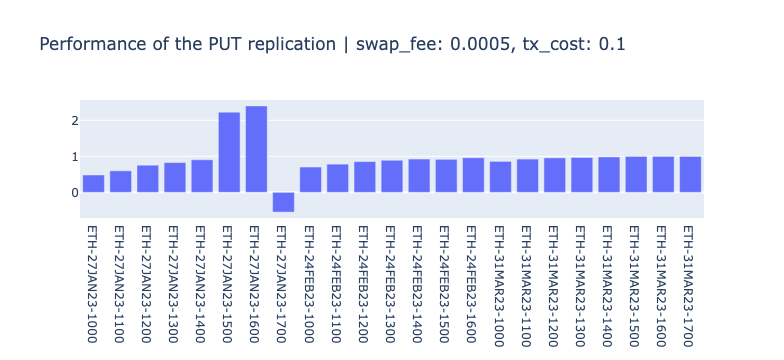

In [467]:
# dices2 = pd.DataFrame(np.random.randint(low=1, high=7, size=(100, 2)), columns=('Кость 1', 'Кость 2'))
# dices2['Сумма'] = dices2['Кость 1'] + dices2['Кость 2']
# dices3 = pd.DataFrame(np.random.randint(low=1, high=7, size=(1000, 2)), columns=('Кость 1', 'Кость 2'))
# dices3['Сумма'] = dices3['Кость 1'] + dices3['Кость 2']

fig = go.Figure(layout = {"title": {"text": '''Performance of the {} replication | swap_fee: {}, tx_cost: {}'''.format(option_type.upper(), swap_fee, tx_cost)}})
# fig.add_trace(go.Histogram(x=dices['Сумма']))
for i in range(len(res)):
    # fig.add_trace(go.Histogram(x=r))
    # fig.add_trace(go.Histogram(x=r))
    fig2 = px.bar(res[i], x=np.array([res[i][0]]), y=np.array([res[i][1]]))
    
    # fig2 = px.bar(df, x="x", y="y")
    fig.add_trace(fig2.data[0])

# fig.add_trace(go.Histogram(x=dices3['Сумма']))
fig.show()

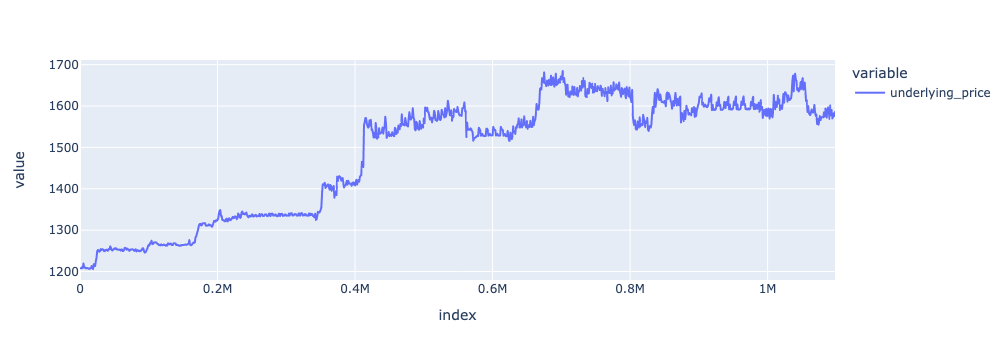

In [468]:
plotly.plot(df[df.index % 1000 == 0]['underlying_price'], 'line')